<a href="https://colab.research.google.com/github/aaoiii/2024-ESAA-OB/blob/main/9%EC%A3%BC%EC%B0%A8_%ED%8C%8C%EB%A8%B8%EC%99%84_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

- price: 제품 가격, 예측을 위한 타깃 속성
- shipping : 배송비 무료 여부 (1이면 무료)
- item_description : 제품 설명

## 데이터 전처리

In [16]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

In [17]:
mercari_df=pd.read_csv('train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(139004, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...


In [18]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139004 entries, 0 to 139003
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           139004 non-null  int64  
 1   name               139004 non-null  object 
 2   item_condition_id  139003 non-null  float64
 3   category_name      138436 non-null  object 
 4   brand_name         79471 non-null   object 
 5   price              139003 non-null  float64
 6   shipping           139003 non-null  float64
 7   item_description   139003 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 8.5+ MB
None


<ipython-input-19-858dfb81a9ec>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df,kde=False)


<Axes: xlabel='price'>

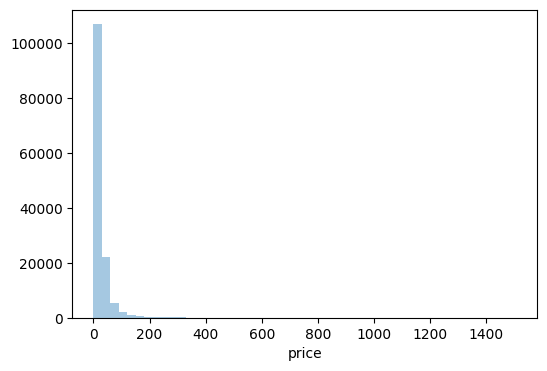

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

<ipython-input-20-faf24d23e56a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df,kde=False)


<Axes: xlabel='price'>

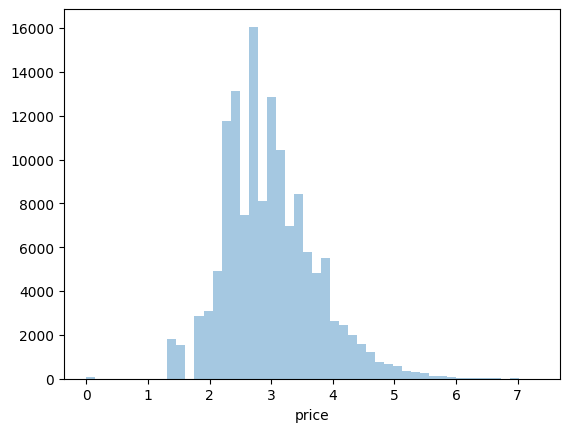

In [20]:
import numpy as np
y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

In [21]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [22]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0.0    76784
1.0    62219
Name: count, dtype: int64
item_condition_id값 유형:
 item_condition_id
1.0    59903
3.0    40470
2.0    35442
4.0     2964
5.0      224
Name: count, dtype: int64


In [23]:
boolen_cond = mercari_df['item_description'] =='No description yet'
mercari_df[boolen_cond]["item_description"].count()

7866

- 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경해야한다

- category_name : '/'로 분리된 카테고리를 하나의 문자열로 나타낸다
- 별도의 split_cat()함수를 생성
  - category_name이 Null이 아닌 경우에 split을 이용해 대,중,소 (cat_dae, cat_jung, cat_so) 분류를 분리
  - Null이면 error를 except catch하여 대,중,소 분류 모두 'Other Null' 부여
- 판다스의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 DataFrame칼럼으로 분리해야하는 것이 고민해야할 점
  - zip과 *를 apply lambda 식에 적용하여 칼럼으로 분리

In [24]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환

def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ["Other_Null","Other_Null","Other_Null"]

In [25]:
# 위의 split_cat()을 apply lambda에서 호출해 대,중,소 칼럼을 mercari_df에 생성
mercari_df["cat_dae"], mercari_df["cat_jung"], mercari_df["cat_so"] = \
                                               zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))

In [26]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류 소분류는 값의 유형이 많으므로 분류 개수만 추출
print("대분류 유형: \n", mercari_df["cat_dae"].value_counts())
print("중분류 유형: \n", mercari_df["cat_jung"].nunique())
print("소분류 유형: \n", mercari_df["cat_so"].nunique())

대분류 유형: 
 cat_dae
Women                     62411
Beauty                    19554
Kids                      16142
Electronics               11448
Men                        8780
Home                       6327
Vintage & Collectibles     4293
Other                      4264
Handmade                   2870
Sports & Outdoors          2347
Other_Null                  568
Name: count, dtype: int64
중분류 유형: 
 112
소분류 유형: 
 727


- Women, Beauty, Kids 등의 분류가 많다


In [29]:
# brand_name, category_name, item_description칼럼의 Null값은 일괄적으로 'Other_Null'로 변경
mercari_df["brand_name"] = mercari_df["brand_name"].fillna(value="Other_Null")
mercari_df["category_name"] = mercari_df["category_name"].fillna(value="Other_Null")
mercari_df["item_description"] = mercari_df["item_description"].fillna(value="Other_Null")

In [ ]:
mercari_df.isnull().sum()

## 피처 인코딩과 피처 벡터화
- Price를 예측하는 것 => 회귀 기반
- 인코딩할 피처는 모두 원핫인코딩
- 피처벡터화 : 짧은 텍스트는 Count기반 벡터화, 긴 텍스트는 TD-IDF 기반 벡터화

In [ ]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

In [ ]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 10건: \n', mercari_df['name'][:10])

- Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태이므로 Count기반의 피처 벡터화 변환 적용

In [32]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.33705504877557


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- 평균 문자열이 비교적 크므로 item_description 칼럼은 TF-IDF로 변환 적용

In [ ]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

- CountVectorizer, TfidVectorizer가 fit_transform을 통해 반환하는 데이터는 희소 행렬 형태
- 인코딩 대상 칼럼도 희소 형렬 형태로 인코딩을 적용한 뒤, 함께 결합
- LabelBinarizer : 희소 행렬 형태의 원핫 인코딩 변환 지원 sparse_out=True로 지정
- 개별 칼럼으로 만들어진 희소행렬은 사이파이 패키지 sparse 모듈의 hstack()함수(희소행렬을 손쉽게 칼럼 레벨로 결합할 수 있도록 해줌)를 이용해 결합


In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape{1}'.format(X_cat_jung.shape, X_cat_so.shape))

- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csv_matrix


In [ ]:
# 피처 벡터화 변환 데이터세트와 희소 인코딩 변환 데이터세트를 hstack()를 이용해 결합

from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()


- hstack으로 결합한 데이터 세트는 csr_matrix 타입
- 데이터 세트에 회귀 적용해보기

## 릿지 회귀 모델 구축 및 평가
- 평가로직 : RMSLE(Root Mean Square Logarithmic Error)

In [35]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환되었으므로 expm1로 원상복귀 필요
  preds_expm = np.expm1(preds)
  y_test_expm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_expm, preds_expm)
  return rmsle_result

- 학습용 데이터 생성하고, 모델을 학습 예측하는 로직

In [36]:
def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- Ridge를 이용해 Mercari Price 회귀 예측 수행
- Item_description 속성의 피처 벡터화 데이터의 포함여부에 따라 예측 성능이 어떻게 달라지는지 비교하기

In [ ]:
linear_model = Ridge(solver = 'lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

- LightGBM을 이용해 회귀를 수행, 위의 릿지모델 예측값과 LightGBM모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

- 위의 LightGBM 예측 결괏값과 위의 Ridge 예측 결괏값 앙상블해 최종 예측 결괏값 도출

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

##정리

<머신러닝 기반 텍스트 분석 프로세스>
1. 텍스트 사전 정제 작업등의 텍스트 정규화 작업

2. 단어들을 피처 벡터화로 변환

3. 생성된 피처 벡터 데이터 세트에 머신러닝 모델 학습, 예측, 평가

**텍스트 정규화**
- 텍스트 클렌징, 대소문자 변경, 단어 토큰화, 의미없는 단어 필터링, 어근 추출
- BOW 대표 방식인 Count 기반, TF-IDF 기반 피처 벡터화
- 만들어진 피처 벡터 데이터 세트는 희소 행렬
- 머신러닝 모델을 희소 행렬 기반에서 최적화되어야함

-----------------------------------------
- 문서들을 피처벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 분류
- 감성 분석
  - 지도학습 기반 긍/부정 이진분류
  - 감성사전 Lexicon을 이용한 방식
- 토픽 모델링
  - LDA를 이용
- 텍스트 군집화
  - K-평균 군집화 기법
  - 텍스트 유사도 측정은 코사인 유사도 이용